In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [3]:
import os
all_files = glob.glob('/media/ck/Elements/Africa/WestAfrica/CP4/CP4hist/lsRain/lsRain_*')

months = np.array(['07', '08','09'])#np.array(['06','07','08','09'])#([ '03', '04', '05', '06', '09', '10', '11'])

hist_files = []
#del allhist
for alls in all_files:
    if alls[-11:-9] not in months:
        continue
    else:
        hist_files.append(alls)
#hist_files = all_files

In [4]:
dummy = xr.open_dataset(hist_files[0], decode_times=False).sel(longitude=slice(-19,30), latitude=slice(4,30))
grid = dummy.salem.grid.regrid(factor=0.27) # at 15km
dummy_trans, lut = grid.lookup_transform(dummy['lsRain'], return_lut=True)

KeyboardInterrupt: 

In [ ]:
histlist = []
for f in hist_files:
    print('Doing', f)
    cph = xr.open_dataset(f, decode_times=False).sel(longitude=slice(-19,30), latitude=slice(4,30))
    prcp = cph['lsRain']*3600
    
    dat_prcp = grid.lookup_transform(prcp, lut=lut, method=np.mean)
    ds = grid.to_dataset()
    prcp = xr.DataArray(dat_prcp, coords=[prcp['time'],ds['y'], ds['x']], dims=['time','latitude','longitude'])
    
    #ipdb.set_trace()
    if prcp.values.ndim != 3:
        continue
#     isin = prcp.max(axis=0)
#     pos = np.where(isin < 5)

    

    prcp = prcp.max(axis=0) #sum
    prcp.values[prcp.values<5] = np.nan
    
    if np.nanmin(prcp.values)<5:
        ipdb.set_trace()
    histlist.append(prcp)
    #plt.contourf(prcp)
    #ipdb.set_trace()
allhist = xr.concat(histlist, dim='dummy', coords='minimal', compat='override')
del cph

In [ ]:
hm = allhist.quantile(0.95, dim='dummy')
hm.to_netcdf('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_p95Rain_gt5mm.nc')

In [ ]:
if np.nanmin(allhist.isel(dummy=slice(1,100))) <1:
    print('SOMETHING WRONG WITH DATA')

In [ ]:
all_files = glob.glob('/media/ck/Elements/Africa/WestAfrica/CP4/CP4fut/lsRain/lsRain_*')
import os
months = np.array(['07', '08','09'])#np.array(['06','07','08','09'])#([ '03', '04', '05', '06', '09', '10', '11'])

fut_files = []
#del allfut
for alls in all_files:
    if alls[-11:-9] not in months:
        continue
    else:
        fut_files.append(alls)
#fut_files = all_files

In [ ]:
futlist = []
for f in fut_files:
    cph = xr.open_dataset(f, decode_times=False).sel(longitude=slice(-20,20), latitude=slice(3.5,25))
    prcp = cph['lsRain']*3600
    
    dat_prcp = grid.lookup_transform(prcp, lut=lut, method=np.mean)
    ds = grid.to_dataset()
    prcp = xr.DataArray(dat_prcp, coords=[prcp['time'],ds['y'], ds['x']], dims=['time','latitude','longitude'])
    
    if prcp.values.ndim != 3:
        continue
    isin = prcp.max(axis=0)
    pos = np.where(isin < 5)

    prcp = prcp.sum(axis=0)
    prcp.values[pos] = np.nan

    if np.nanmin(prcp.values)<5:
        ipdb.set_trace()
    futlist.append(prcp)
allfut = xr.concat(futlist, dim='dummy', coords='minimal', compat='override')
del cph

In [ ]:
fm = allfut.quantile(0.95, dim='dummy')
fm.to_netcdf('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_p95Rain_gt5mm.nc')

In [ ]:
sahel_hist = allhist.sel(latitude=slice(8,12), longitude=slice(-10,10)).values
sahel_fut = allfut.sel(latitude=slice(8,12), longitude=slice(-10,10)).values

In [ ]:
sahel_hist = sahel_hist.flatten()[np.isfinite(sahel_hist.flatten())]
sahel_fut = sahel_fut.flatten()[np.isfinite(sahel_fut.flatten())]

In [ ]:
f = plt.figure(figsize=(13,9), dpi=100)
ax = f.add_subplot(111)
#ipdb.set_trace()
nball, allcount, bins = u_stat.histo_frequency(sahel_hist, bins=np.arange(1, 120, 2))
#ipdb.set_trace()
bin_centre = bins[0:-1] + ((bins[1::] - bins[0:-1]) / 2)
cumulative = np.cumsum(nball)
ax.plot(bin_centre,cumulative, marker='o', markersize=1)

#ipdb.set_trace()
nball, allcount, bins = u_stat.histo_frequency(sahel_fut, bins=np.arange(1, 120, 2))
#ipdb.set_trace()
bin_centre = bins[0:-1] + ((bins[1::] - bins[0:-1]) / 2)
cumulative = np.cumsum(nball)
ax.plot(bin_centre,cumulative,  marker='o', markersize=1)
plt.axhline(0.5, linestyle='dashed', color='k')
plt.axhline(0.8, linestyle='dashed', color='k')
plt.axvline(0.8, linestyle='dashed', color='k')

In [5]:
hm = xr.open_dataarray('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_p95Rain_gt5mm.nc')
fm = xr.open_dataarray('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_p95Rain_gt5mm.nc')
hm = hm.sel(latitude=slice(3.5,25), longitude=slice(-20,20))
fm = fm.sel(latitude=slice(3.5,25), longitude=slice(-20,20))

In [6]:
def draw_map(ax, dat, lat, lon, title='', levels=None, label=None, cmap=None):
   
    plt.contourf(lon, lat, dat, transform=ccrs.PlateCarree(), extend='both', levels=levels, cmap=cmap)
    ax.coastlines()
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    xl.right_labels = False
    xl.bottom_labels = bl
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--');
    ax.set_facecolor('lightgrey')
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(label)

In [7]:
## a clean way of plotting - use matplotlib functions directly:

def draw_map_wind(ax, data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):

    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'], color='white')
        qk = plt.quiverkey(qu, 0.9, 0.03, 4, '4 m s$^{-1}$',
                           labelpos='E', coordinates='figure')
        
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    xl.xlines = False
    xl.ylines=False
    xl.right_labels = False
    xl.left_labels = False
    xl.bottom_labels = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)
    plt.tight_layout()
    #plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/conny_examples/850hpa_rh_ERA5_peru.png')

NameError: name 'bl' is not defined

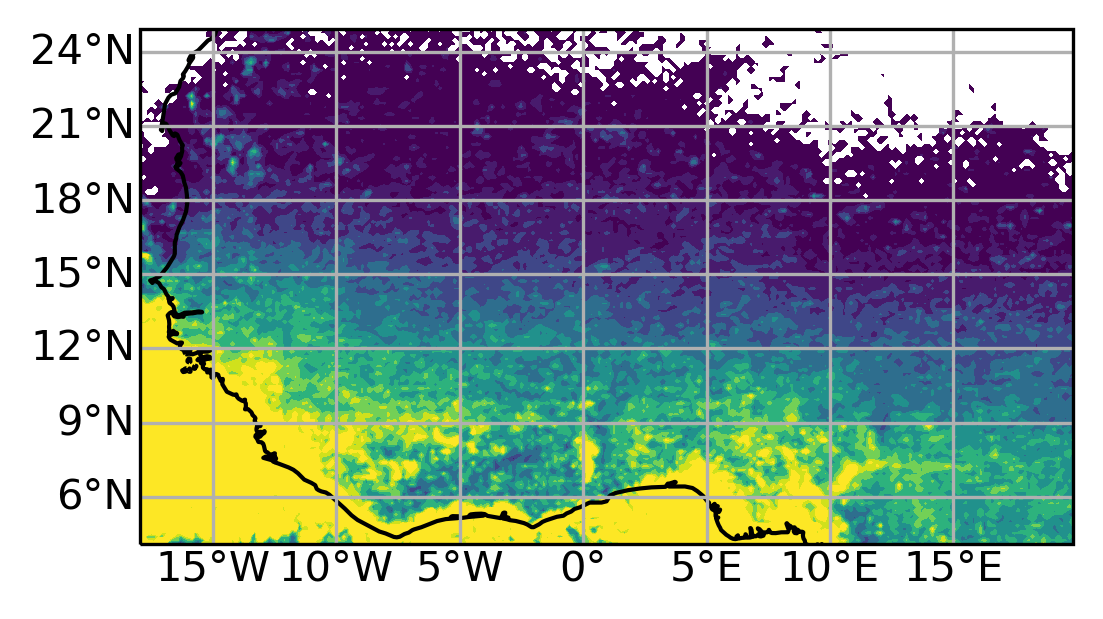

In [8]:
f = plt.figure(figsize=(15,5), dpi=300)

ax = f.add_subplot(221, projection=ccrs.PlateCarree())
draw_map(ax, hm, hm.latitude, hm.longitude, title='Historical P95 daily rain (May-Oct)', levels=np.arange(30,101,10), label=r'mm day$^-1$')
ax1 = f.add_subplot(222, projection=ccrs.PlateCarree())
draw_map(ax1, fm, fm.latitude, fm.longitude, title='Future P95 daily rain (May-Oct)', levels=np.arange(30,101,10), label=r'mm day$^-1$')
ax1 = f.add_subplot(223, projection=ccrs.PlateCarree())
draw_map(ax1, (fm-hm), fm.latitude, fm.longitude, title='Difference P95 rain (Fut-Hist)', levels=np.arange(0,60,10), label=r'mm day$^-1$')
ax1 = f.add_subplot(224, projection=ccrs.PlateCarree())
draw_map(ax1, (fm-hm)/hm*100, fm.latitude, fm.longitude, title='Percentage increase P95 (Fut-Hist/Hist)', levels=[5,10,20,30,40,50,60,70,80], label=r'%')
plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/rory_check/daily_median_percentIncrease_May-Oct.jpg')

In [9]:
tcw_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_q925.nc')
tcw_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_q925.nc')

In [10]:
box = [-23,0,4.5,17]
#box=[-23,-5,6,18]

In [11]:
ttcw_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_tcwv_daily.nc')
ttcw_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_tcwv_daily.nc')

In [12]:
t_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_t925.nc')

t_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_t925.nc')
import metpy
from metpy import calc
from metpy.units import units

In [13]:
u_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_u925.nc')
u_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_u925.nc')

v_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_v925.nc')
v_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_v925.nc')

In [14]:
u_diff = u_fut['u_pl']-u_hist['u_pl'].sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))
v_diff = v_fut['v_pl']-v_hist['v_pl'].sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))

mask = (u_diff > 2) | (v_diff > 2)
u_diff = u_diff.where(mask)
v_diff = v_diff.where(mask)

In [15]:
st=10
sarrow = 2
xquiv = u_diff.longitude[sarrow::st]
yquiv = u_diff.latitude[sarrow::st]

uu = (u_diff.values)[sarrow::st, sarrow::st]
vv = (v_diff.values)[sarrow::st, sarrow::st]

qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : vv, 'scale' : 50}

In [16]:
tcw_diff = tcw_fut#-tcw_hist
t_diff = t_fut#-t_hist
ttcw_diff = ttcw_fut-ttcw_hist

In [17]:
tcw_diff = tcw_diff['q_pl'].sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))/100/1000
tcw_hist = tcw_hist['q_pl'].sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))/100/1000

ttcw_diff = ttcw_diff['tcwv'].sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))
ttcw_hist = ttcw_hist['tcwv'].sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))

t_diff = t_diff['t_pl'].sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))/100+273.15
t_hist = t_hist['t_pl'].sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))/100+273.15

In [18]:
p = units.Quantity(925, 'hPa')
th = units.Quantity(t_hist.values, 'K')
qh = units.Quantity(tcw_hist.values, 'kg/kg')

tf = units.Quantity(t_diff.values, 'K')
qf = units.Quantity(tcw_diff.values, 'kg/kg')

rh = calc.relative_humidity_from_specific_humidity(qh, th, p)
rf = calc.relative_humidity_from_specific_humidity(qf, tf, p)

In [19]:
tf.shape

(308, 444)

In [20]:
ttcw_diff.shape

(309, 445)

In [21]:
(ttcw_diff-ttcw_hist)[1::,:].shape

(308, 445)

In [22]:
((ttcw_diff/ttcw_hist*100)[1::,:])/(tf-th)

ValueError: operands could not be broadcast together with shapes (308,445) (308,444) 

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


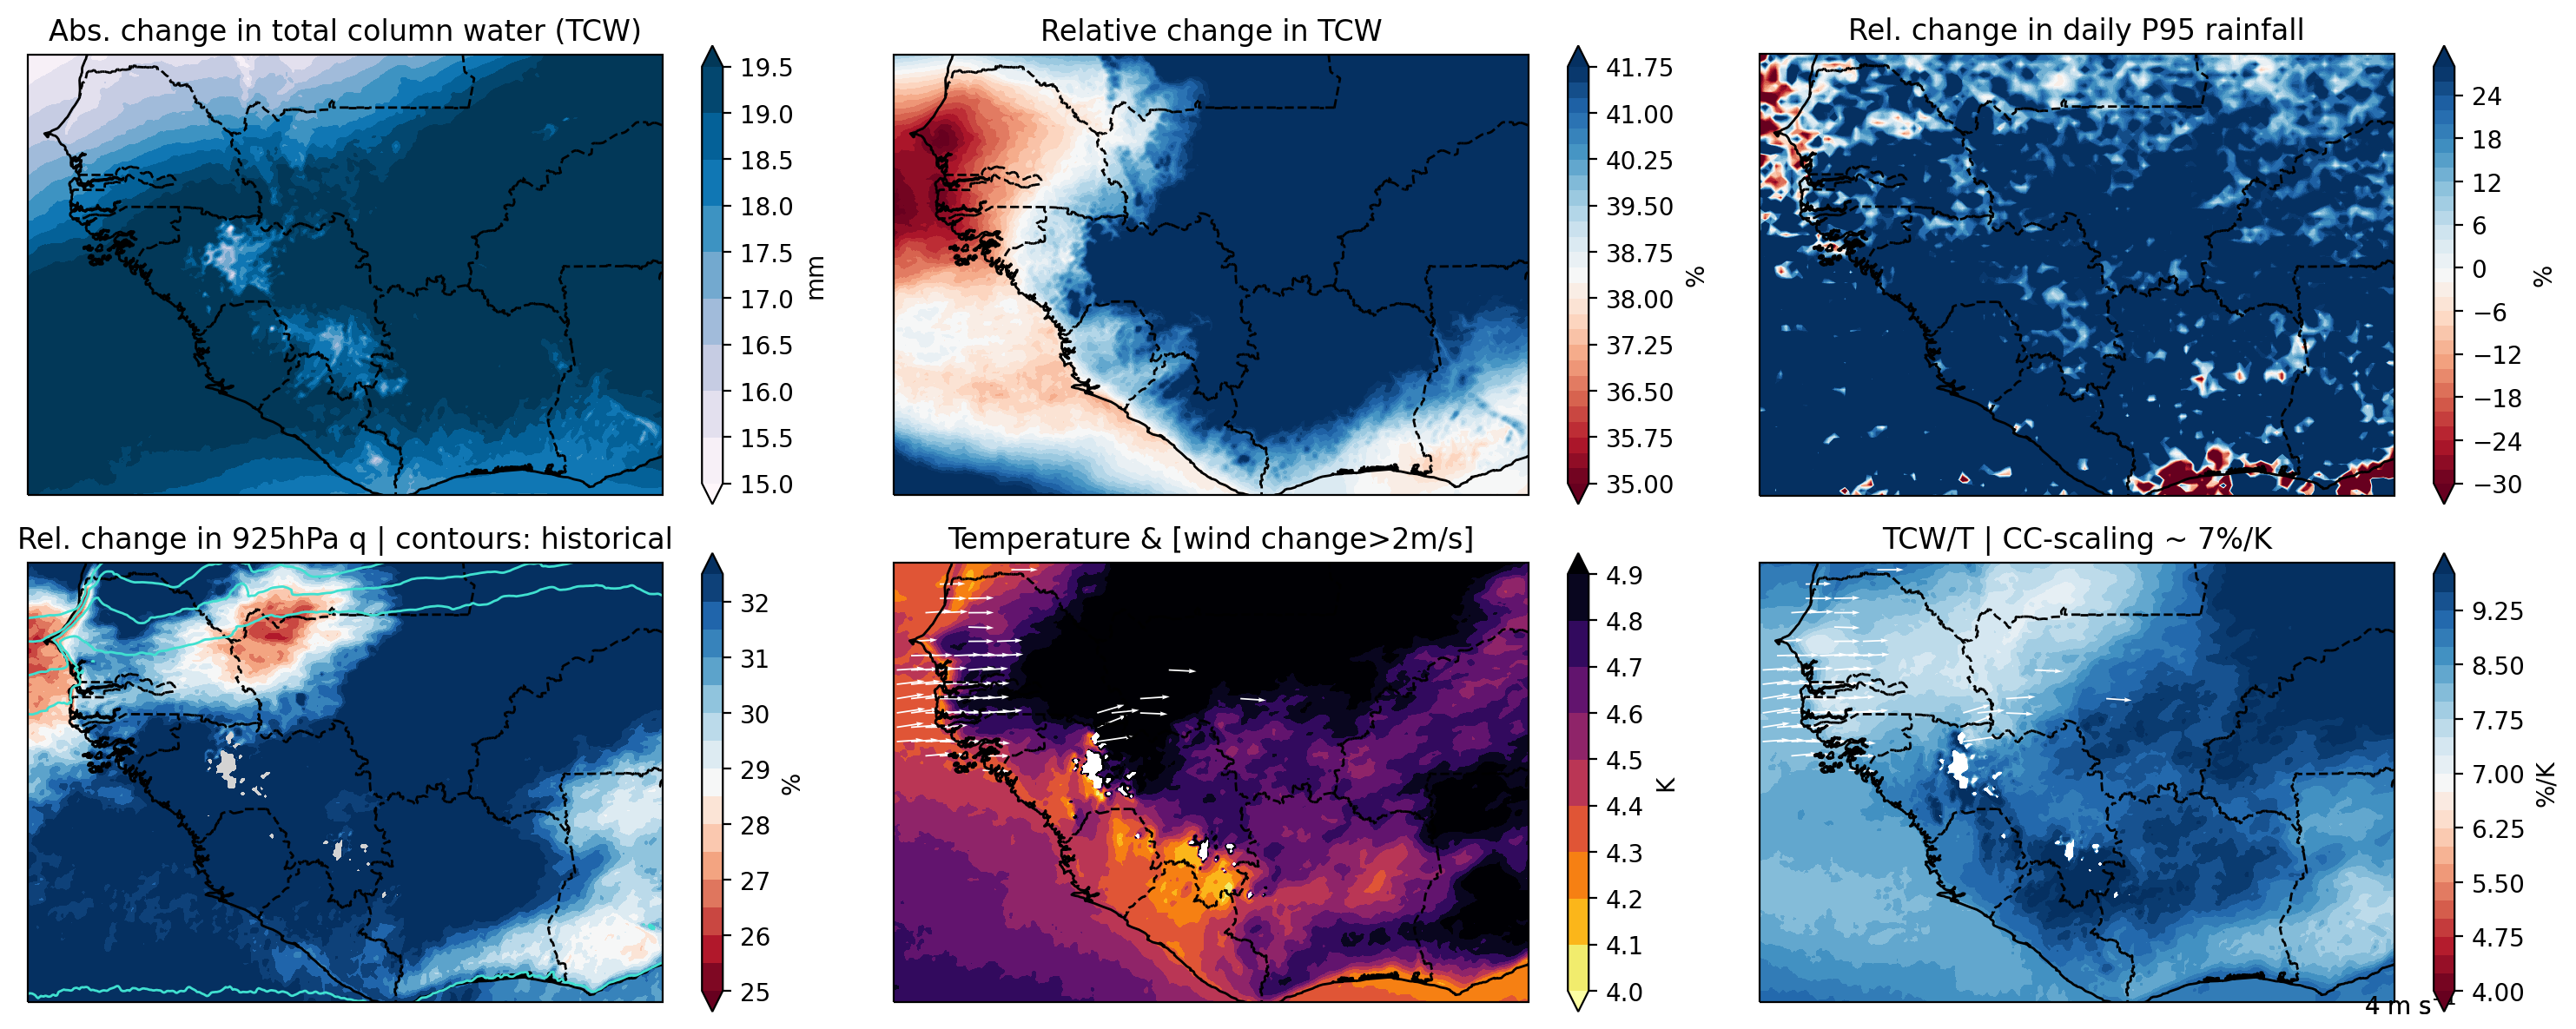

In [31]:
def draw_map(ax, dat, lat, lon, title='', levels=None, label=None, cmap=None):
   
    plt.contourf(lon, lat, dat, transform=ccrs.PlateCarree(), extend='both', levels=levels, cmap=cmap)
    ax.coastlines()
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    xl.left_labels = False
    xl.xlines = False
    xl.ylines=False
    xl.bottom_labels = False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--');
    ax.set_facecolor('lightgrey')
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(label)


f = plt.figure(figsize=(15,6), dpi=200)   #13,7.5

ax2 = f.add_subplot(231, projection=ccrs.PlateCarree())
draw_map(ax2, ttcw_diff, ttcw_diff.latitude, ttcw_diff.longitude, title='Abs. change in total column water (TCW)', levels=np.arange(15,20,0.5), label=r'mm', cmap='PuBu')
#plt.pcolormesh(ttcw_diff.values)
               
ax = f.add_subplot(232, projection=ccrs.PlateCarree())
draw_map(ax, ttcw_diff/ttcw_hist*100, ttcw_diff.latitude, ttcw_diff.longitude, title='Relative change in TCW', levels=np.arange(35,42,0.25), label=r'%', cmap='RdBu')

# ax1 = f.add_subplot(223, projection=ccrs.PlateCarree())
# draw_map(ax1, (rf-rh)*100, t_diff.latitude, t_diff.longitude, title='Change in 925hPa relative humidity', levels=[-4,-3,-2,-1,1,2,3,4], label=r'%', cmap='RdBu')
               


# ax1 = f.add_subplot(233, projection=ccrs.PlateCarree())
# testrain = ((fm-hm)/hm*100).sel(latitude=slice(box[2],box[3]), longitude=slice(box[0], box[1]))
# draw_map(ax1, testrain, testrain.latitude, testrain.longitude, title='Rel. change in daily P95 rainfall', levels=np.arange(-70,71,10), label=r'%', cmap='RdBu')

ax1 = f.add_subplot(233, projection=ccrs.PlateCarree())
testrain = ((fm-hm)).sel(latitude=slice(box[2],box[3]), longitude=slice(box[0], box[1]))
draw_map(ax1, testrain, testrain.latitude, testrain.longitude, title='Rel. change in daily P95 rainfall', levels=np.arange(-30,30,2), label=r'%', cmap='RdBu')

# ax1 = f.add_subplot(224, projection=ccrs.PlateCarree())
# draw_map(ax1, (qf-qh)*1000/(qh*1000)*100, t_diff.latitude, t_diff.longitude, title='Relative change in 925hPa specific humidity', levels=np.arange(25,35,1), label=r'%', cmap='RdBu')

ax1 = f.add_subplot(234, projection=ccrs.PlateCarree())
draw_map(ax1, (qf-qh)*1000/(qh*1000)*100, t_diff.latitude, t_diff.longitude, title='Rel. change in 925hPa q | contours: historical', levels=np.arange(25,33,0.5), label=r'%', cmap='RdBu')
#draw_map(ax1, (qf)*1000, t_diff.latitude, t_diff.longitude, title='Rel. change in 925hPa specific humidity', levels=np.arange(10,20,0.5), label=r'g/kg', cmap='RdBu')
plt.contour(t_diff.longitude, t_diff.latitude, (qf)*1000,levels=[15,16,17,18], colors='turquoise', linewidths=1, transform=ccrs.PlateCarree())

ax1 = f.add_subplot(235, projection=ccrs.PlateCarree())


draw_map_wind(ax1, (tf-th), t_diff.longitude, t_diff.latitude, title='Temperature & [wind change>2m/s]',  quiver=qin, cbar_label='K', cmap='inferno_r', levels=np.arange(4,5, 0.1), extend='both')

ax1 = f.add_subplot(236, projection=ccrs.PlateCarree())
draw_map_wind(ax1, ((ttcw_diff/ttcw_hist*100))[1::,1::]/(tf-th), t_diff.longitude, t_diff.latitude, title='TCW/T | CC-scaling ~ 7%/K',  quiver=qin, cbar_label='%/K', cmap='RdBu', levels=np.arange(4,10, 0.25), extend='both')

#[1::,:]
plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CP4_TCW_RH_change_WADomain.jpg')

In [179]:
ttcw_diff.values/(t_diff-t_hist).values

ValueError: operands could not be broadcast together with shapes (297,297) (296,296) 

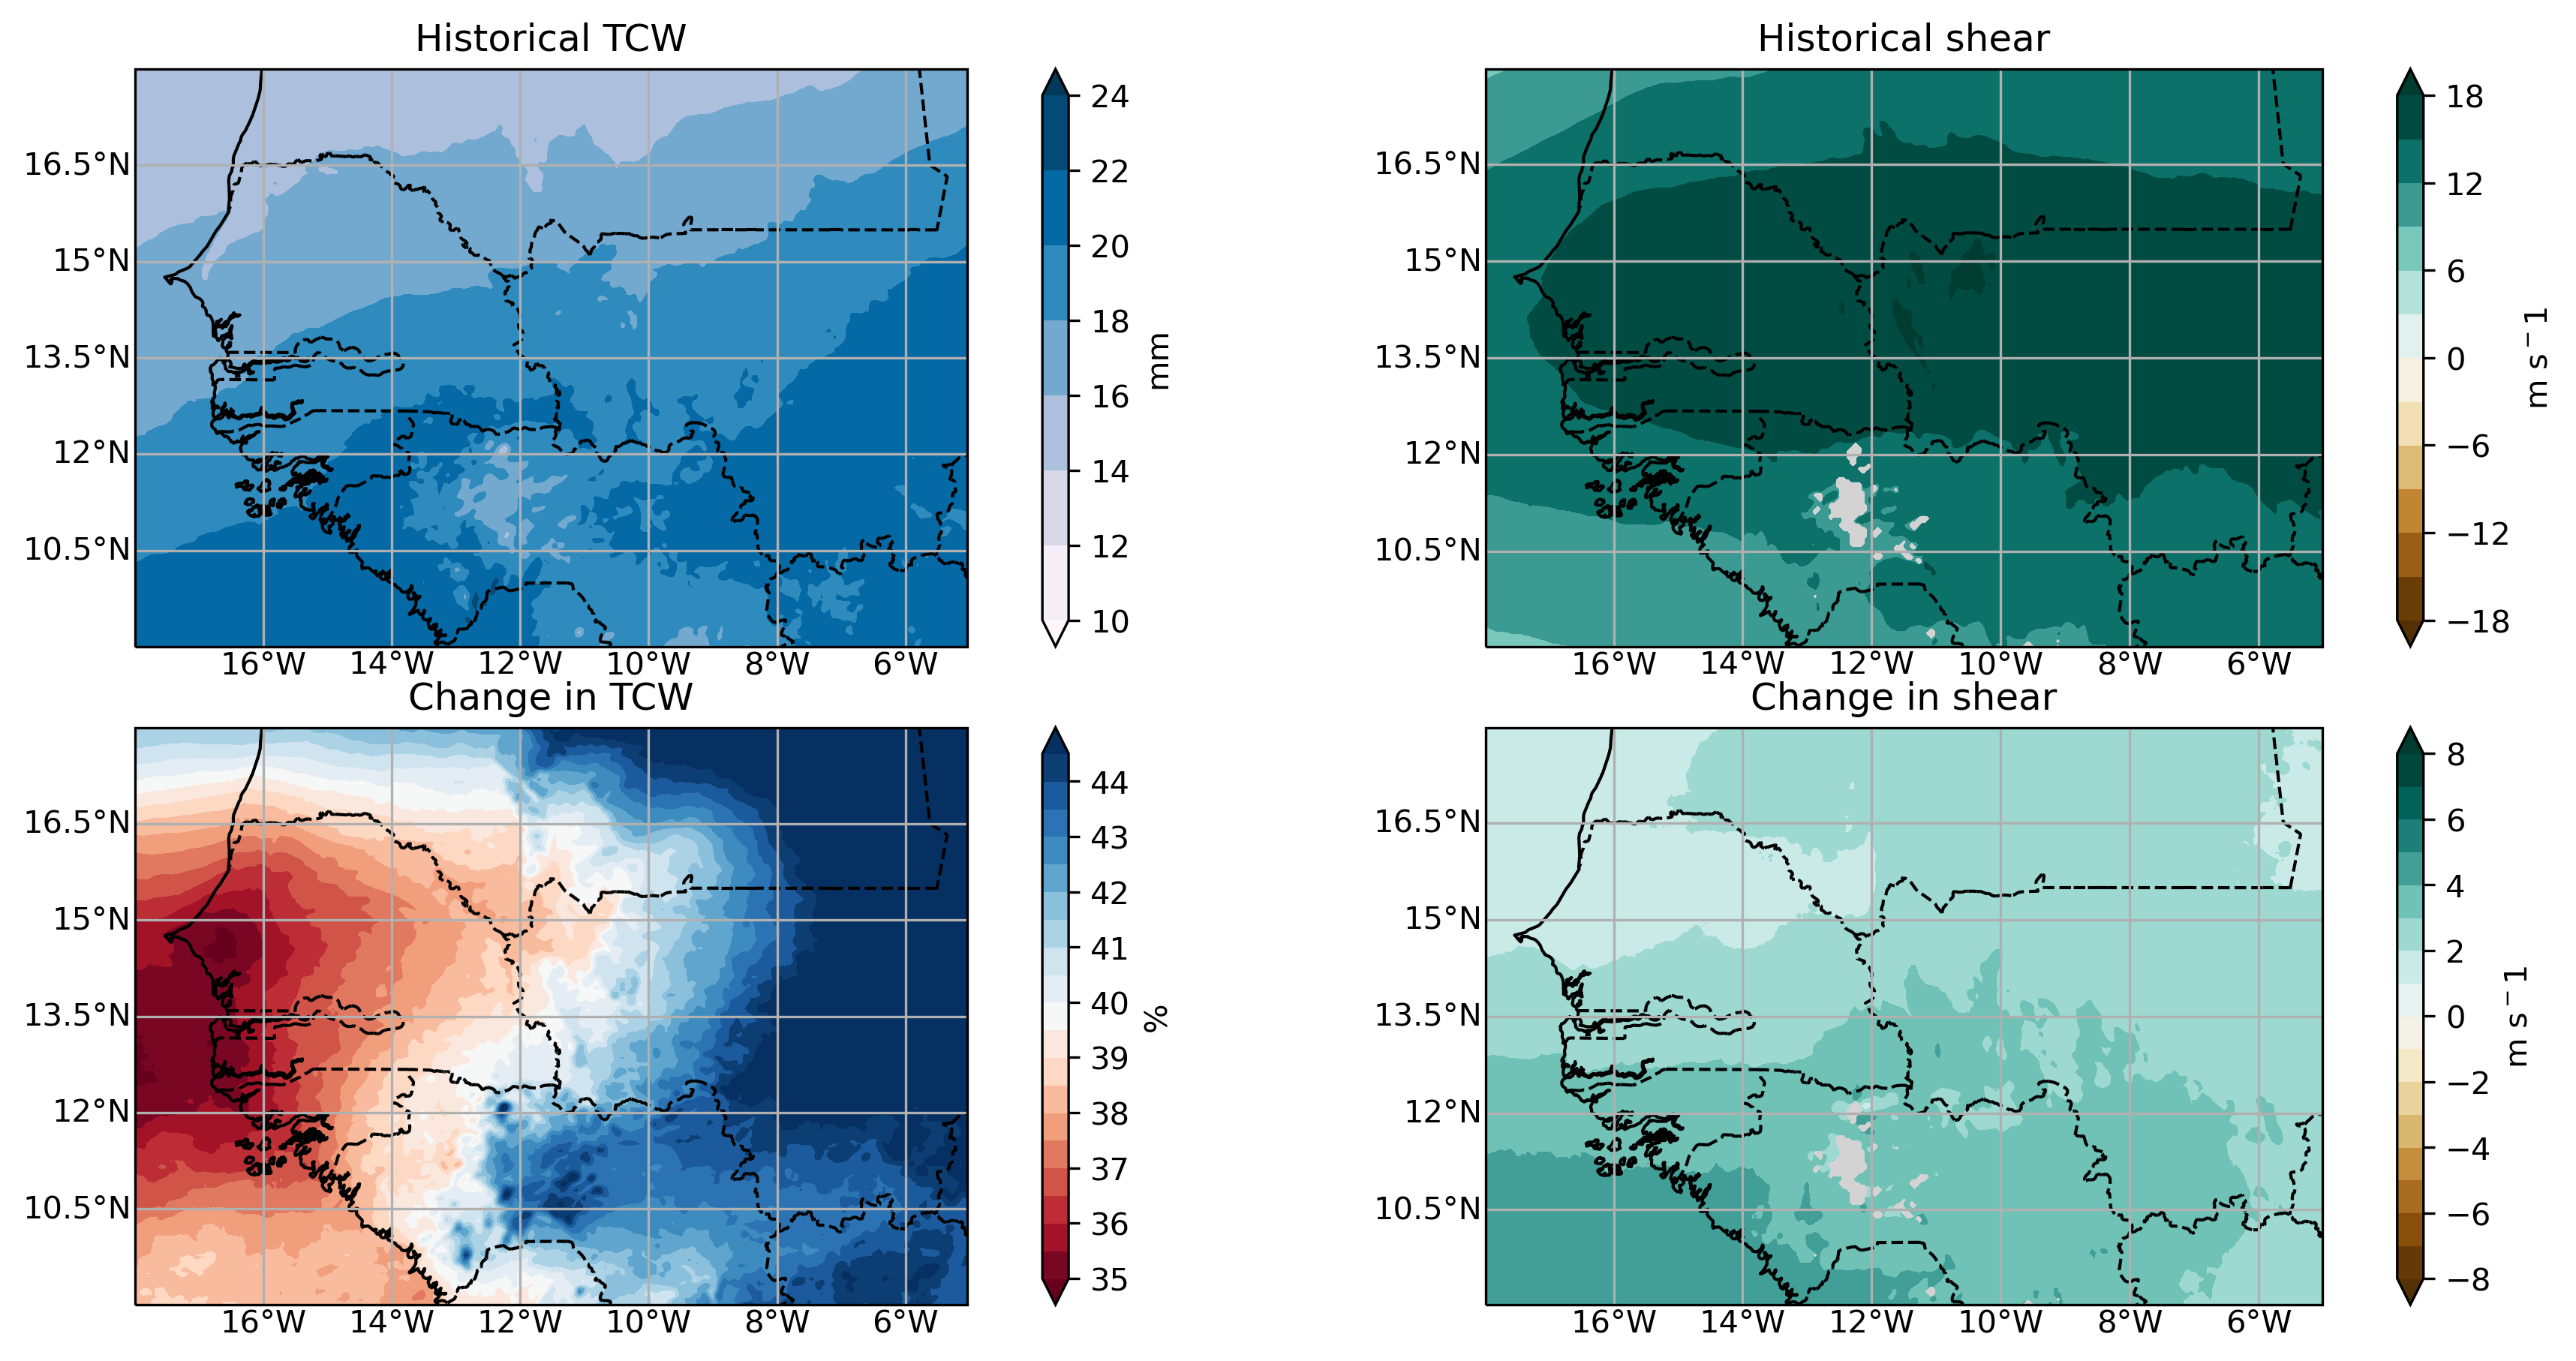

In [56]:
f = plt.figure(figsize=(13,6), dpi=300)

ax2 = f.add_subplot(221, projection=ccrs.PlateCarree())
draw_map(ax2, tcw_diff.where(tcw_hist>25), tcw_diff.latitude, tcw_diff.longitude, title='Historical TCW', levels=np.arange(10,25,2), label=r'mm', cmap='PuBu')
ax3 = f.add_subplot(222, projection=ccrs.PlateCarree())
draw_map(ax3, shear_hist, shear_diff.latitude, shear_diff.longitude, title='Historical shear', levels=np.arange(-18,19,3), label=r'm s$^-1$', cmap='BrBG')


ax = f.add_subplot(223, projection=ccrs.PlateCarree())
draw_map(ax, tcw_diff.where(tcw_hist>25)/tcw_hist*100, tcw_diff.latitude, tcw_diff.longitude, title='Change in TCW', levels=np.arange(35,45,0.5), label=r'%', cmap='RdBu')
ax1 = f.add_subplot(224, projection=ccrs.PlateCarree())
draw_map(ax1, shear_diff, shear_diff.latitude, shear_diff.longitude, title='Change in shear', levels=np.arange(-8,9,1), label=r'm s$^-1$', cmap='BrBG')
plt.tight_layout()
f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CP4_TCWSHEAR_change.jpg')

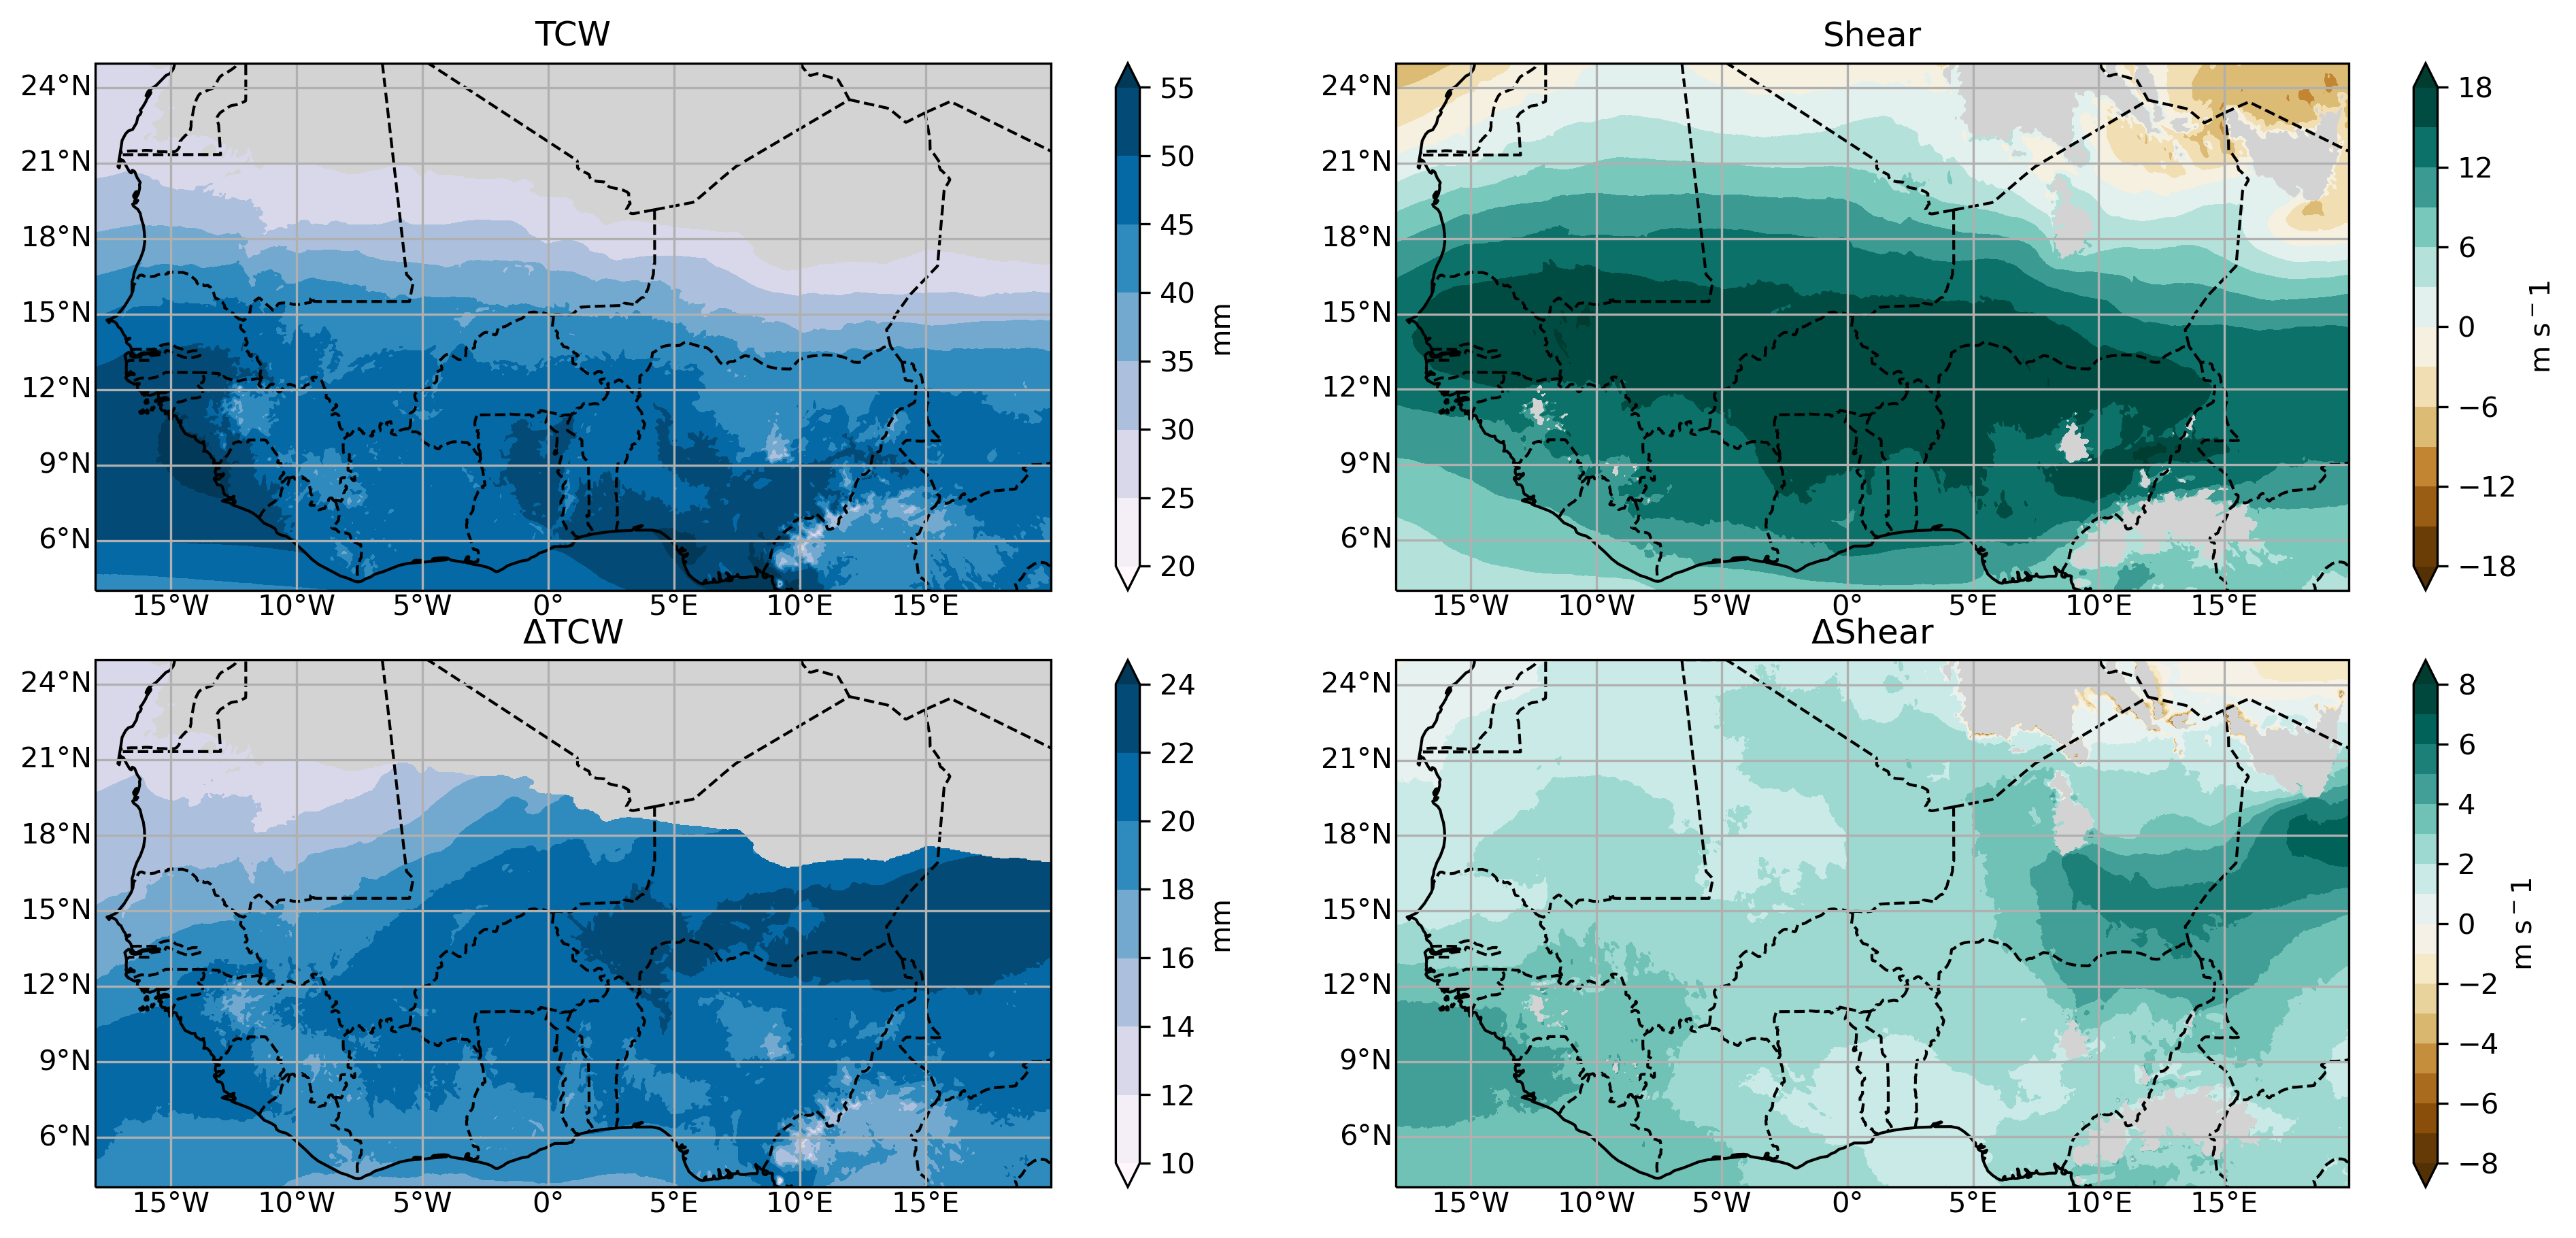

In [21]:
f = plt.figure(figsize=(13,6), dpi=300)

ax2 = f.add_subplot(221, projection=ccrs.PlateCarree())
draw_map(ax2, tcw_hist.where(tcw_hist>25), tcw_diff.latitude, tcw_diff.longitude, title='TCW', levels=np.arange(20,56,5), label=r'mm', cmap='PuBu')
ax3 = f.add_subplot(222, projection=ccrs.PlateCarree())
draw_map(ax3, shear_hist, shear_diff.latitude, shear_diff.longitude, title='Shear', levels=np.arange(-18,19,3), label=r'm s$^-1$', cmap='BrBG')


ax = f.add_subplot(223, projection=ccrs.PlateCarree())
draw_map(ax, tcw_diff.where(tcw_hist>25), tcw_diff.latitude, tcw_diff.longitude, title='$\Delta$TCW', levels=np.arange(10,25,2), label=r'mm', cmap='PuBu')
ax1 = f.add_subplot(224, projection=ccrs.PlateCarree())
draw_map(ax1, shear_diff, shear_diff.latitude, shear_diff.longitude, title='$\Delta$Shear', levels=np.arange(-8,9,1), label=r'm s$^-1$', cmap='BrBG')
plt.tight_layout()
f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CP4_TCWABS_SHEAR_baseline.jpg')

In [19]:
tcw_diff.where(tcw_hist['tcwv']>20).shape

(518, 939)

In [22]:
shearfac = 0.71 # monthly: 0.55
tcwvfac = 3.12 # relative change
tcabsfac = 1.22 # absolute change
tcabserrlow = (tcabsfac-2*0.1)
tcabserrhigh = (tcabsfac+2*0.1)
mmPerPercent = tcabsfac/tcwvfac

# tcwvperr = 0.15 #%
# sherr = 0.051 # mm / shear
# shperr = sherr * mmPerPercent

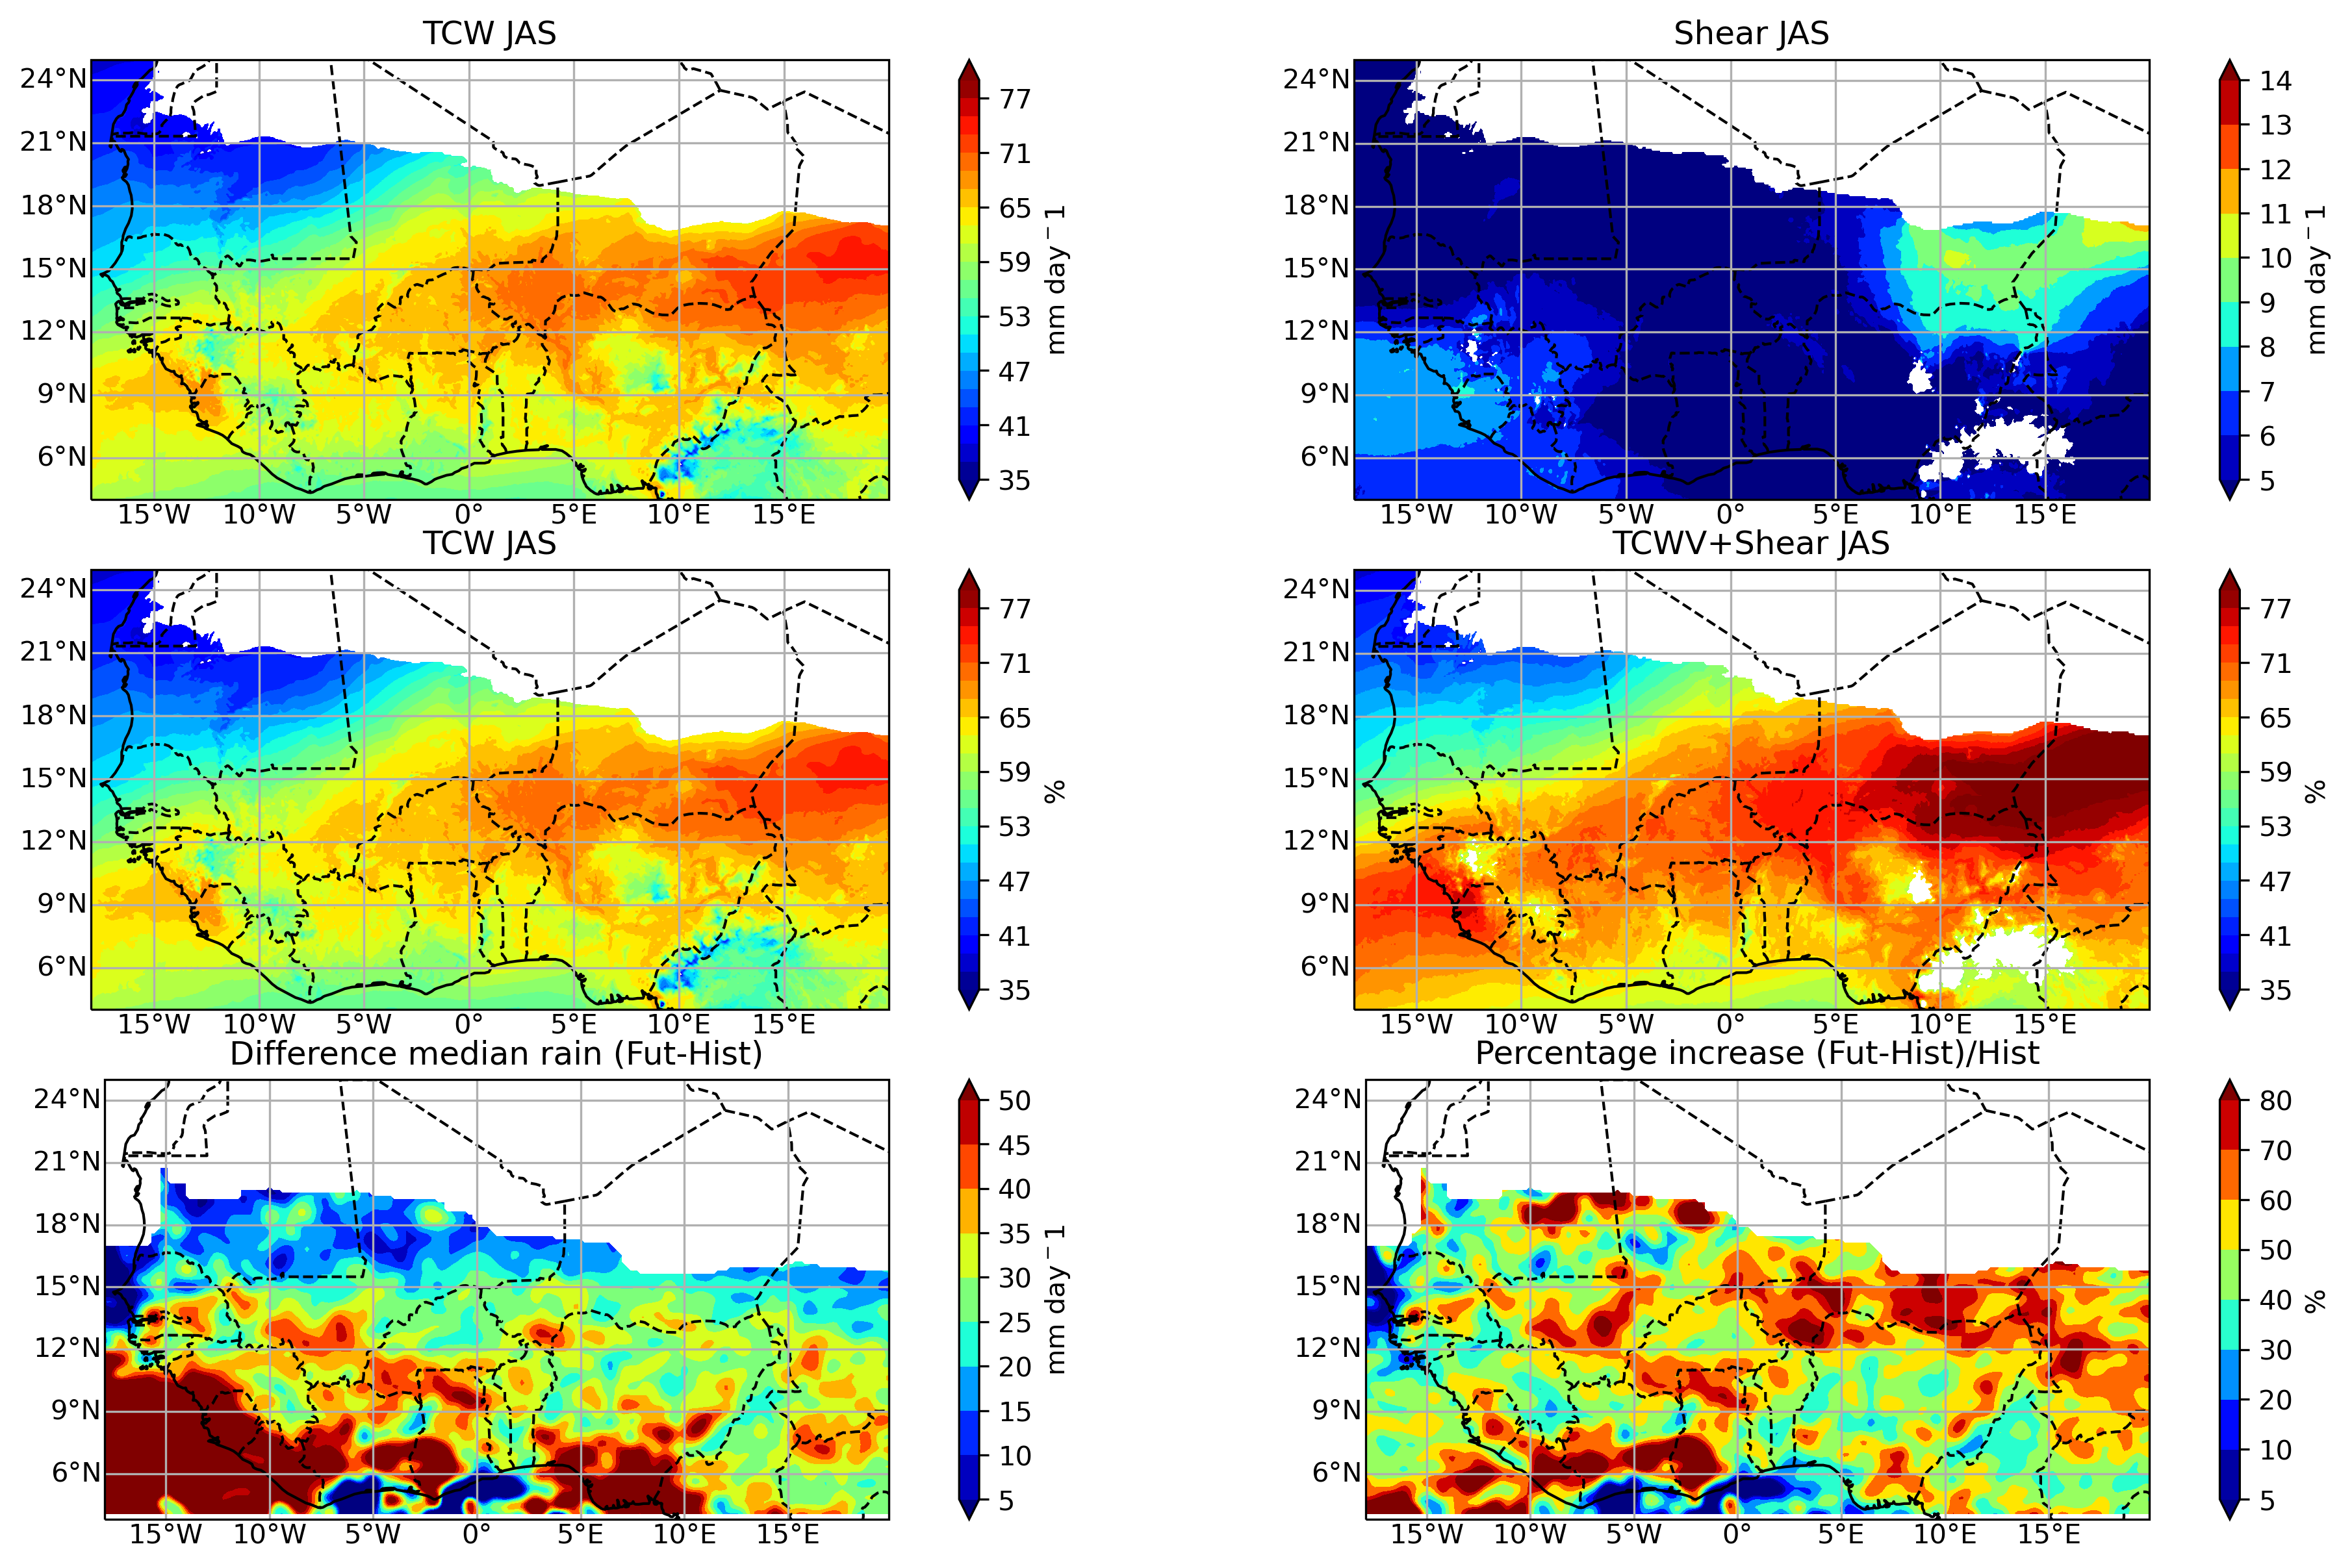

In [42]:
from scipy import ndimage
f = plt.figure(figsize=(14,8), dpi=300)
tthresh = 24.5   # 0.5th centile
thist_on_precip = fm.salem.lookup_transform(tcw_hist['tcwv'])
thist_on_shear = shear_diff.salem.transform(tcw_hist['tcwv'])
tdiff_on_shear = shear_diff.salem.transform(tcw_diff)

#ndimage.gaussian_filter(((dic2['lsta0']) / (dic2['cnt0'])), 2, mode='nearest')

ax = f.add_subplot(321, projection=ccrs.PlateCarree())
draw_map(ax, tcw_diff.where(tcw_hist['tcwv']>tthresh)*tcabsfac/mmPerPercent, tcw_diff.latitude, tcw_diff.longitude, title='TCW JAS', levels=np.arange(35,81,2), label=r'mm day$^-1$')
ax1 = f.add_subplot(322, projection=ccrs.PlateCarree())
draw_map(ax1, shear_diff.where(thist_on_shear>tthresh)*shearfac/mmPerPercent, shear_diff.latitude, shear_diff.longitude, title='Shear JAS', levels=np.arange(5,15,1), label=r'mm day$^-1$')
ax2 = f.add_subplot(323, projection=ccrs.PlateCarree())
draw_map(ax2, tcw_diff.where(tcw_hist['tcwv']>tthresh)*tcabsfac/mmPerPercent, tcw_diff.latitude, tcw_diff.longitude, title='TCW JAS', levels=np.arange(35,81,2), label=r'%')
ax3 = f.add_subplot(324, projection=ccrs.PlateCarree())
draw_map(ax3, ((shear_diff.where(thist_on_shear>tthresh)*shearfac)+(tdiff_on_shear.where(thist_on_shear>tthresh)*tcabsfac))/mmPerPercent, shear_diff.latitude, shear_diff.longitude, title='TCWV+Shear JAS', levels=np.arange(35,81,2), label=r'%')
ax4 = f.add_subplot(325, projection=ccrs.PlateCarree())
ax4.set_ylim(3.8,25)
draw_map(ax4, ndimage.gaussian_filter((fm-hm).where(thist_on_precip>tthresh),2, mode='nearest'), fm.latitude, fm.longitude, title='Difference median rain (Fut-Hist)', levels=[5,10,15,20,25,30,35,40,45,50], label=r'mm day$^-1$')
ax5 = f.add_subplot(326, projection=ccrs.PlateCarree())
ax5.set_ylim(3.8,25)
draw_map(ax5, ndimage.gaussian_filter(((fm-hm)/hm*100).where(thist_on_precip>tthresh),2, mode='nearest'), fm.latitude, fm.longitude, title='Percentage increase (Fut-Hist)/Hist', levels=[5,10,20,30,40,50,60,70,80], label=r'%')
plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/rory_check/daily_median_percentIncrease_May-Oct.jpg')

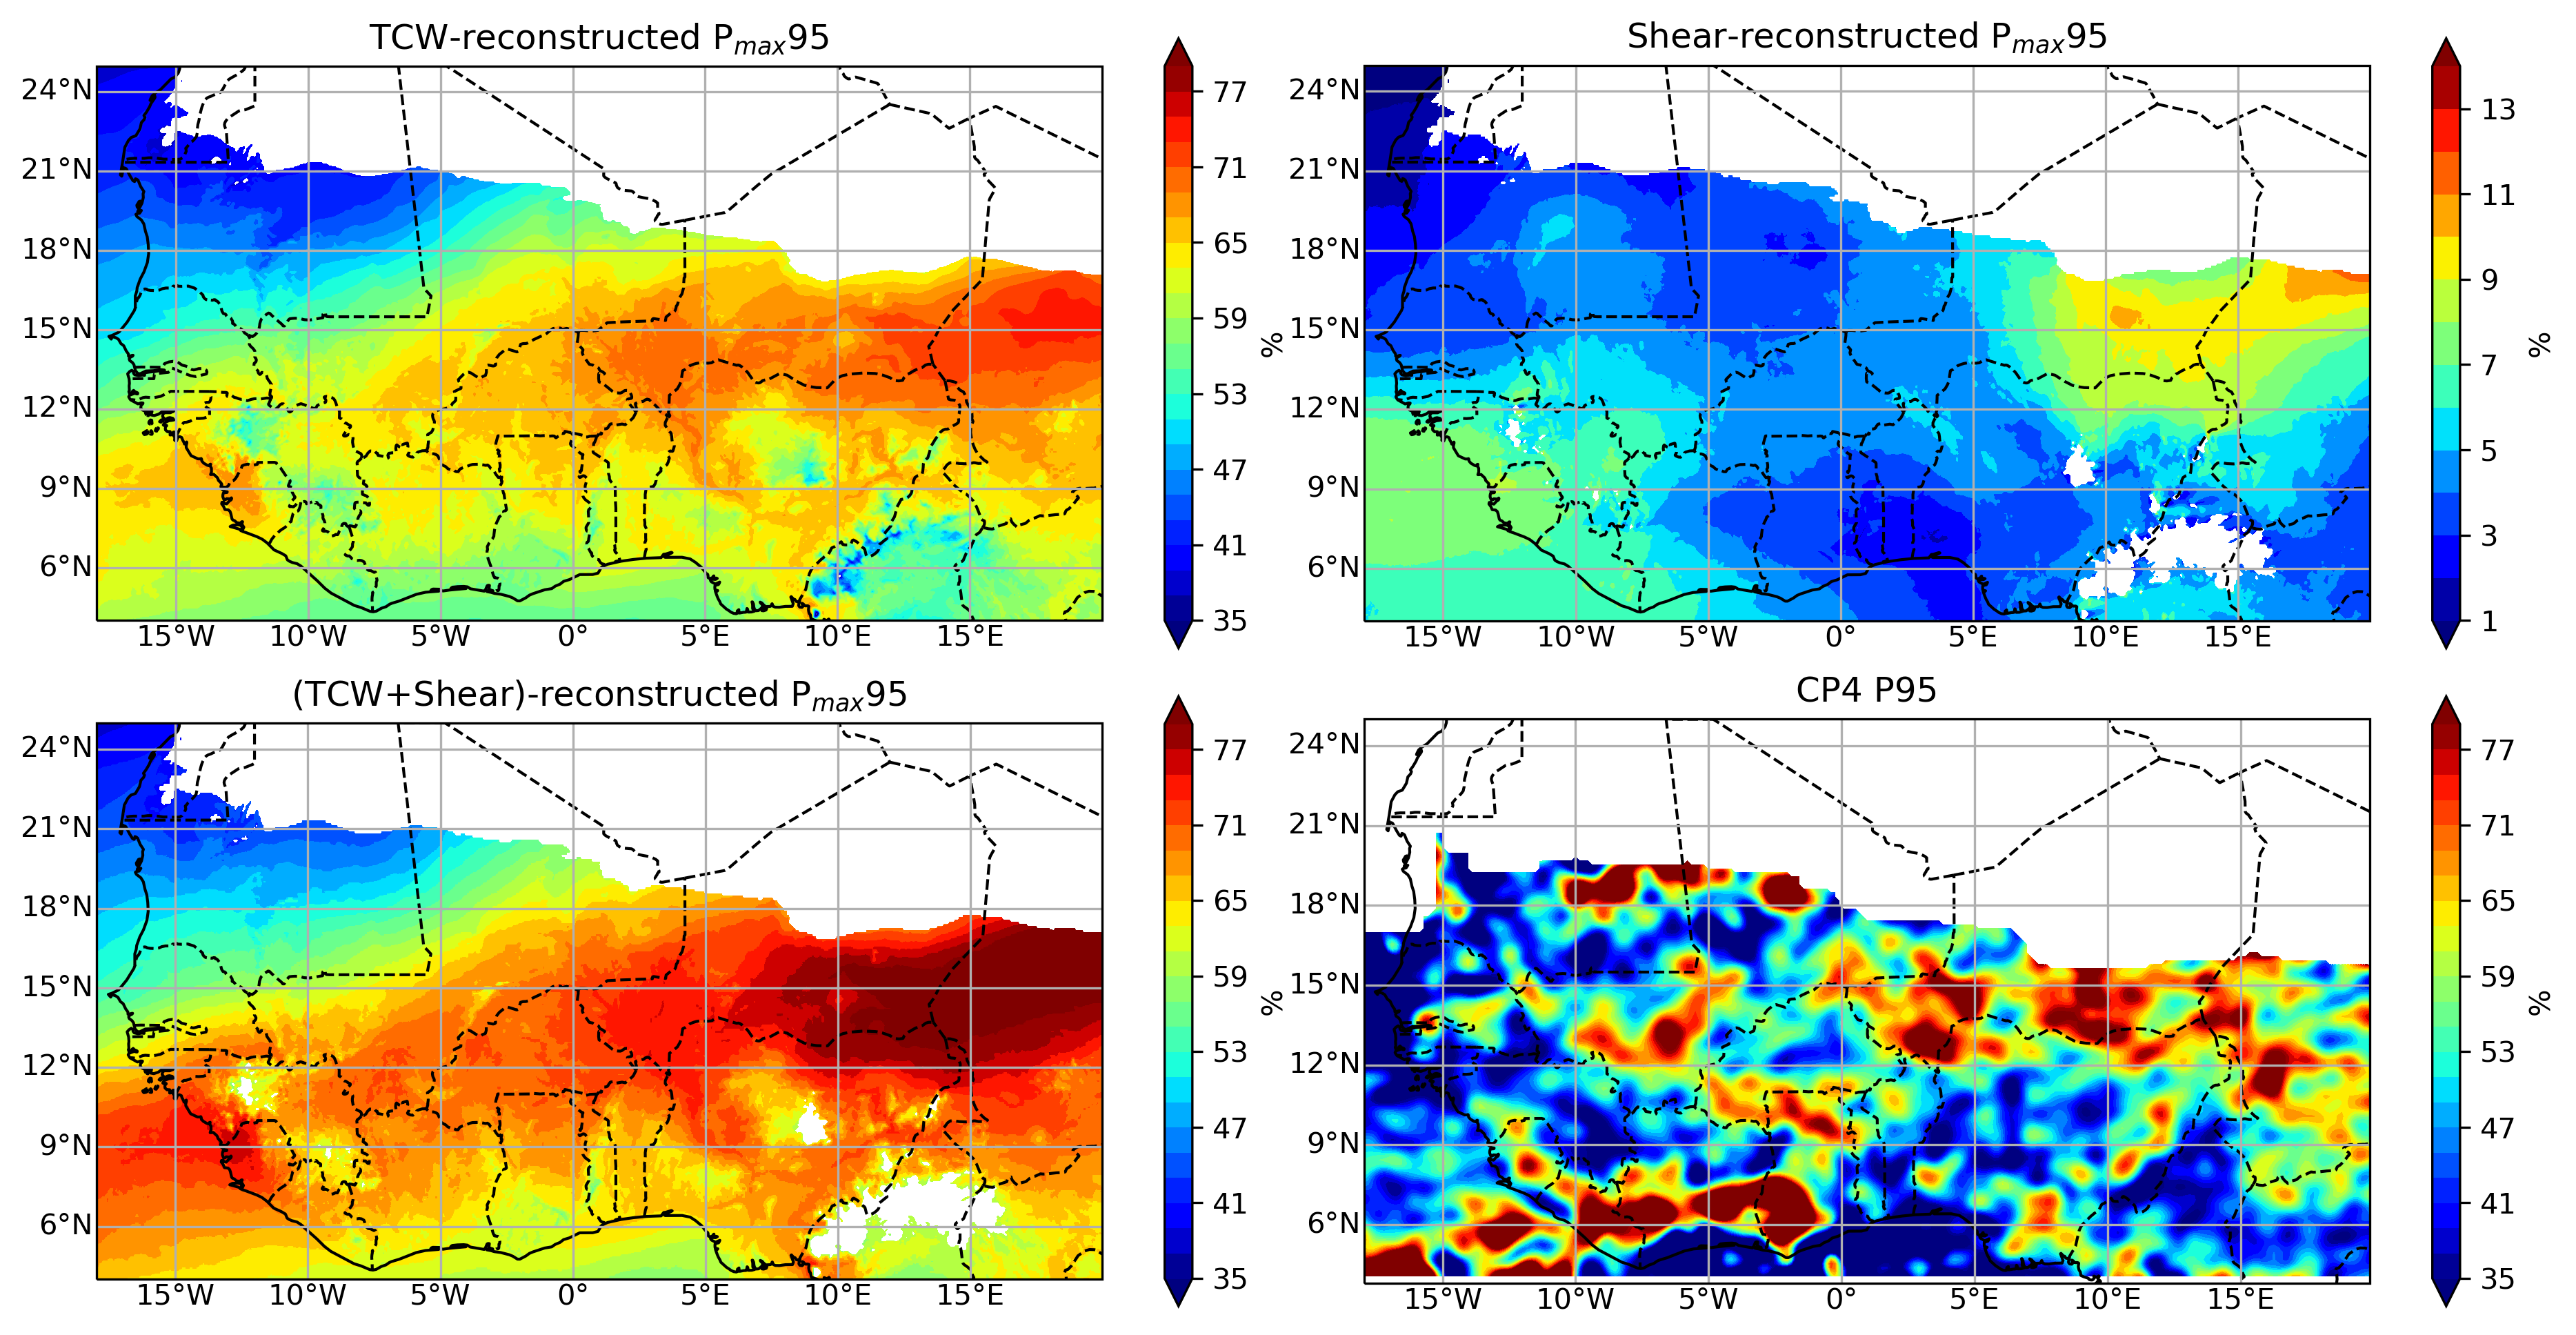

In [49]:
from scipy import ndimage
f = plt.figure(figsize=(12.5,6.5), dpi=300)
tthresh = 24.5   # 0.5th centile
thist_on_precip = fm.salem.lookup_transform(tcw_hist['tcwv'])
thist_on_shear = shear_diff.salem.transform(tcw_hist['tcwv'])
tdiff_on_shear = shear_diff.salem.transform(tcw_diff)

#ndimage.gaussian_filter(((dic2['lsta0']) / (dic2['cnt0'])), 2, mode='nearest')

ax2 = f.add_subplot(221, projection=ccrs.PlateCarree())
draw_map(ax2, tcw_diff.where(tcw_hist['tcwv']>tthresh)*tcabsfac/mmPerPercent, tcw_diff.latitude, tcw_diff.longitude, title='TCW-reconstructed P$_{max}$95', levels=np.arange(35,81,2), label=r'%')
ax3 = f.add_subplot(222, projection=ccrs.PlateCarree())
draw_map(ax3, (shear_diff.where(thist_on_shear>tthresh)*shearfac)/mmPerPercent, shear_diff.latitude, shear_diff.longitude, title='Shear-reconstructed P$_{max}$95', levels=np.arange(1,15,1), label=r'%')
ax3 = f.add_subplot(223, projection=ccrs.PlateCarree())
draw_map(ax3, ((shear_diff.where(thist_on_shear>tthresh)*shearfac)+(tdiff_on_shear.where(thist_on_shear>tthresh)*tcabsfac))/mmPerPercent, shear_diff.latitude, shear_diff.longitude, title='(TCW+Shear)-reconstructed P$_{max}$95', levels=np.arange(35,81,2), label=r'%')

ax5 = f.add_subplot(224, projection=ccrs.PlateCarree())
ax5.set_ylim(3.8,25)
draw_map(ax5, ndimage.gaussian_filter(((fm-hm)/hm*100).where(thist_on_precip>tthresh),2, mode='nearest'), fm.latitude, fm.longitude, title='CP4 P95', levels=np.arange(35,81,2), label=r'%')
plt.tight_layout()
f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CP4_reconstructed_JASrain.jpg')